In [3]:
#importation des librairies nécéssaires
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

dataset = pd.read_csv('AEP_hourly.csv')
dataset = dataset.set_index('Datetime')
dataset.index = pd.to_datetime(dataset.index)

In [4]:
#info du dataset
dataset.info()
dataset.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


(121273, 1)

In [5]:
#comptage du nombre de données manquantes dans le dataset
dataset.isnull().sum()

AEP_MW    0
dtype: int64

In [6]:
#résumé statistique
dataset.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


<AxesSubplot:title={'center':'Consommation électrique en MW'}, xlabel='Datetime'>

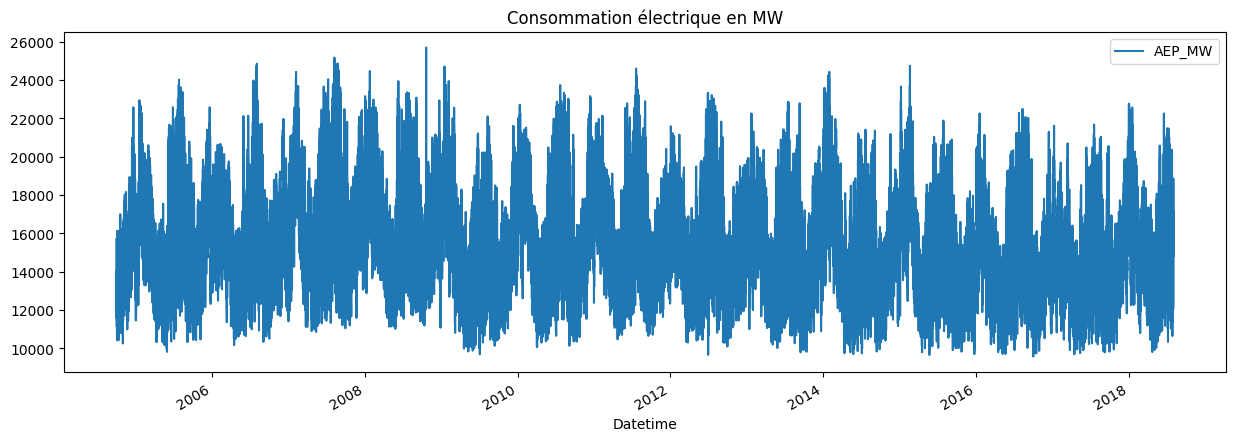

In [7]:
# plot des données 
dataset.plot(figsize=(15,5),title='Consommation électrique en MW')

In [9]:
#regroupements des données par jours,mois et années
# Groupes pour le resampling
daily_groups = dataset.resample('D')
weekly_groups = dataset.resample('W')
monthly_groups = dataset.resample('M')
yearly_groups = dataset.resample('Y')

# Jeux de données resamplés
daily_data = daily_groups.sum()
daily_dataweekly_data = weekly_groups.sum()
weekly_data = weekly_groups.sum()
monthly_data = monthly_groups.sum()
yearly_data = yearly_groups.sum()

In [10]:
weekly_data["week_nb"] = weekly_data.index.isocalendar().week

In [11]:
daily_data["day_of_week"] = daily_data.index.isocalendar().day
daily_data["day_of_year"] = daily_data.index.strftime("%j")

In [12]:
#split train et test
nb_lines = daily_data.shape[0]
train = daily_data.iloc[:int(nb_lines*0.8)]
test = daily_data.iloc[int(nb_lines*0.8)+1:]

In [13]:
train_model = train.groupby(by=["day_of_year"]).mean()
train_model = train_model.rename(columns={"AEP_MW": "prediction"})

In [14]:
def predict(df,model):
    return df.merge(model, on="day_of_year", how="left")

test_predictions = predict(test, train_model)

<AxesSubplot:xlabel='day_of_year'>

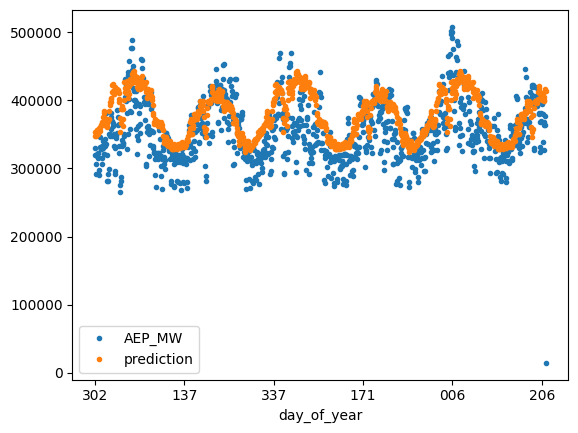

In [13]:
test_predictions.plot(x='day_of_year' ,y=['AEP_MW','prediction'], marker='.', linestyle='none')

In [14]:
#evaluate the prediction :)
print("RMSE %s" %mean_squared_error(test_predictions["AEP_MW"],test_predictions["prediction"], squared=False))
print("MAE %s" %mean_absolute_error(test_predictions["AEP_MW"],test_predictions["prediction"]))


RMSE 45819.38893986183
MAE 36082.749579958


In [1]:
# let's do some ML
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

test_predictions = test

X = train[["day_of_year", "day_of_week"]].values

model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                   ('linear', LinearRegression(fit_intercept=True))])
#model = LinearRegression().fit(X, train["AEP_MW"].values)
model.fit(X, train["AEP_MW"].values)
test_predictions["prediction"] = model.predict(test[["day_of_year", "day_of_week"]].values)

NameError: name 'test' is not defined

<AxesSubplot:xlabel='day_of_year'>

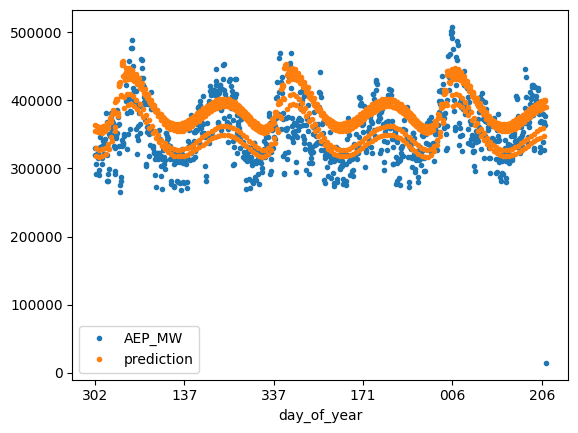

In [47]:
test_predictions.plot(x='day_of_year' ,y=['AEP_MW','prediction'], marker='.', linestyle='none')

In [48]:
#evaluation des prédictions
print("RMSE %s" %mean_squared_error(test_predictions["AEP_MW"],test_predictions["prediction"],squared= False))
print("MSE %s" %mean_absolute_error(test_predictions["AEP_MW"],test_predictions["prediction"]) )

RMSE 43975.71164713449
MSE 34961.37300042017


In [20]:
# xgboost

from sklearn.ensemble import GradientBoostingClassifier

test_predictions = test

X = train[["day_of_year", "day_of_week"]].values

model = Pipeline([('xgboost', GradientBoostingClassifier(n_estimators=2,max_depth=1))])
#model = LinearRegression().fit(X, train["AEP_MW"].values)
model.fit(X, train["AEP_MW"].values)
test_predictions["prediction"] = model.predict(test[["day_of_year", "day_of_week"]].values)

KeyboardInterrupt: 

In [18]:
test

,AEP_MW,day_of_week,day_of_year,prediction
Datetime,,,,
2015-10-29,319717.0,4,302,363697.794619
2015-10-30,329503.0,5,303,355629.307883
2015-10-31,306814.0,6,304,329346.805843
2015-11-01,291351.0,7,305,317784.657506
2015-11-02,318224.0,1,306,354443.185290
...,...,...,...,...
2018-07-30,368834.0,1,211,391897.874743
2018-07-31,364327.0,2,212,401170.556395
2018-08-01,363628.0,3,213,398799.634562


In [19]:
train

,AEP_MW,day_of_week,day_of_year
Datetime,,,
2004-10-01,328544.0,5,275
2004-10-02,311997.0,6,276
2004-10-03,293450.0,7,277
2004-10-04,343417.0,1,278
2004-10-05,346553.0,2,279
...,...,...,...
2015-10-23,312426.0,5,296
2015-10-24,284185.0,6,297
2015-10-25,273661.0,7,298


<AxesSubplot: title={'center': 'daily_data'}, xlabel='Datetime'>

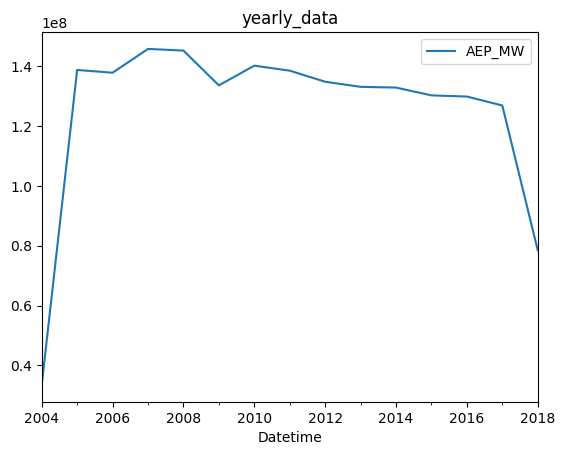

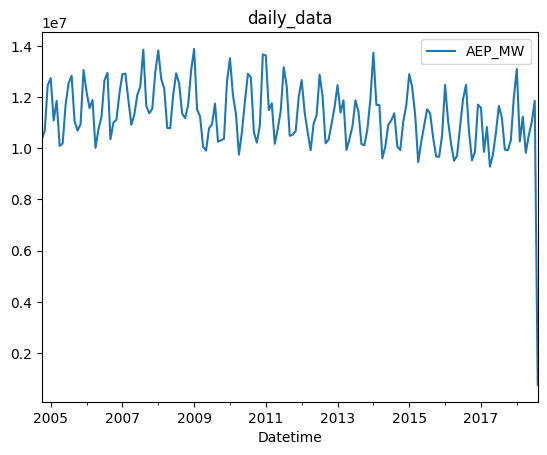

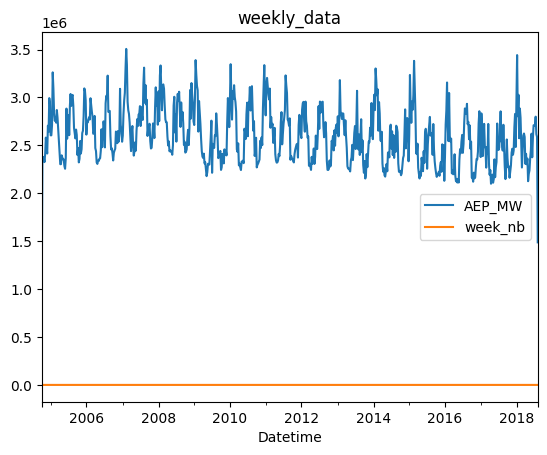

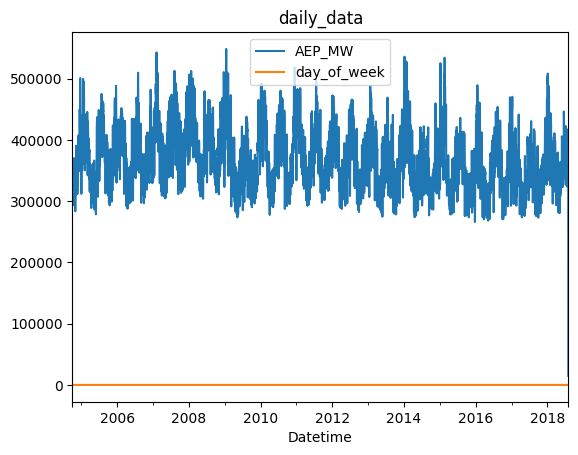

In [50]:
#représentation du dataset en fct des jours, mois et années
yearly_data.plot(title='yearly_data')
monthly_data.plot(title='daily_data')
weekly_data.plot(title='weekly_data')
daily_data.plot(title='daily_data')

<AxesSubplot: title={'center': 'week of data'}, xlabel='Datetime'>

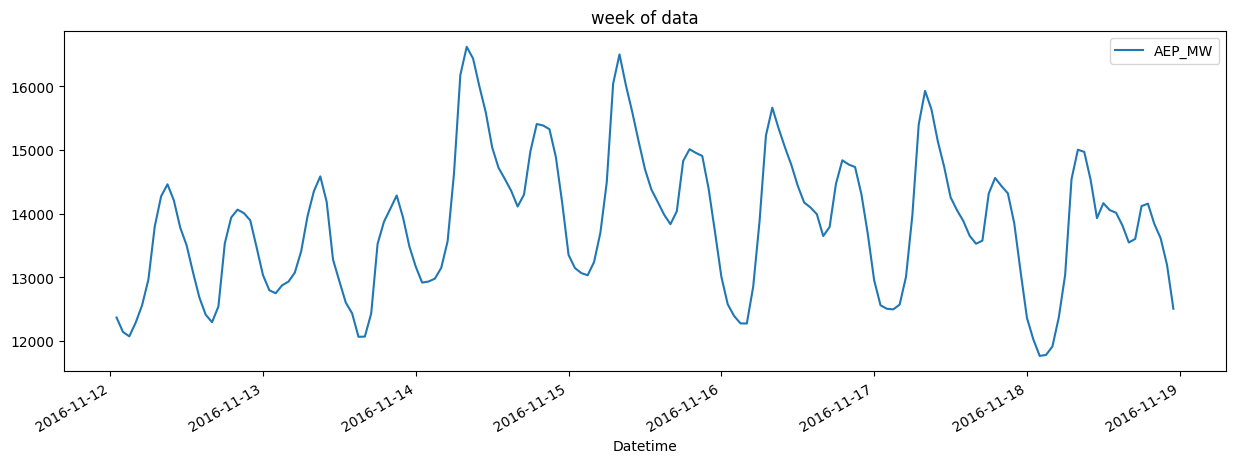

In [37]:
#une semaine de données (sam 12 nov 2016 -sam 19 nov)
dataset.loc[(dataset.index>'2016-11-12') & (dataset.index < '2016-11-19')] .plot(figsize=(15,5),title='week of data')

<AxesSubplot: title={'center': 'two days of data'}, xlabel='Datetime'>

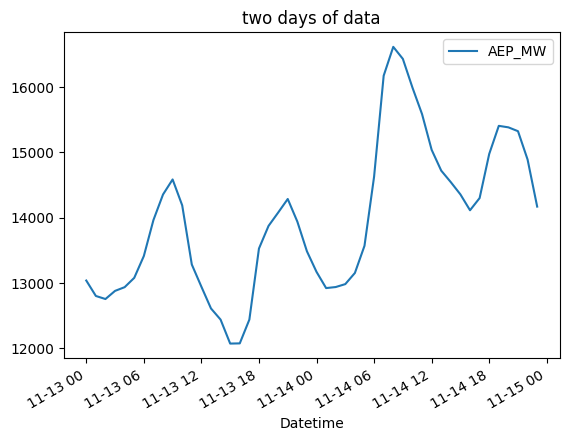

In [38]:
#deux journées de données dimanche 13 nov 2016 et lundi 14 nov
dataset.loc[(dataset.index>='2016-11-13') & (dataset.index <'2016-11-15')].plot(title='two days of data')
